# Gradient-based Model Inversion Attack against Federated Learning

In this tutorial, we will experiment gradient-based model inversion attack, which allows the malicious server of Federated Learning to reconstruct the private local dataset via shared gradients. You can implement five popular gradient-based model inversion attacks with AIJack. These methods reconstruct the private images by minimizing the distance between the fake gradients and the received gradients. Each method has its own strategy, such as the distance metric and regularization terms.

## Thư viện

In [2]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from numpy import e
from matplotlib import pyplot as plt
import torch.optim as optim
from tqdm.notebook import tqdm

from aijack.collaborative.fedavg import FedAVGAPI, FedAVGClient, FedAVGServer
from aijack.attack.inversion import GradientInversionAttackServerManager
from torch.utils.data import DataLoader, TensorDataset
from aijack.utils import NumpyDataset

import warnings

warnings.filterwarnings("ignore")

## Mô hình

In [3]:
# Resnet model

import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet20(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 16, 3, stride=1)
        self.layer2 = self._make_layer(16, 32, 3, stride=2)
        self.layer3 = self._make_layer(32, 64, 3, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(in_channels, out_channels, stride))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
# LeNet model

class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(nn.Linear(hideen, num_classes))

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Data 

1. MNIST  -  (LeNet hoặc MLP) ko cần resnet vì ảnh đơn giản
- Loại dữ liệu: Ảnh chữ số viết tay (đen trắng).
- Kích thước ảnh: 28x28 pixel, 1 kênh (grayscale).
- Số lớp: 10 (các chữ số từ 0 đến 9).
- Số lượng mẫu: 70,000 (60,000 ảnh huấn luyện, 10,000 ảnh kiểm tra).
2. LFW (Labeled Faces in the Wild)  -  (ResNet hoặc FaceNet)
- Loại dữ liệu: Ảnh khuôn mặt (màu, RGB).
- Kích thước ảnh: 62x47 pixel, 3 kênh (RGB).
- Số lớp:
- Phụ thuộc vào chế độ sử dụng:
- Binary classification: Nhận diện cặp ảnh có cùng danh tính hay không.
- Multi-class classification: Phân loại dựa trên danh tính (5,749 danh tính trong dataset đầy đủ).
- Số lượng mẫu: 13,233 ảnh khuôn mặt từ 5,749 người.
3. CIFAR-10  -  (ResNet và LFW)
- Loại dữ liệu: Ảnh màu (RGB).
- Kích thước ảnh: 32x32 pixel, 3 kênh (RGB).
- Số lớp: 10 (máy bay, ô tô, chim, mèo, hươu, chó, ếch, ngựa, tàu, xe tải).
- Số lượng mẫu: 60,000 (50,000 ảnh huấn luyện, 10,000 ảnh kiểm tra).
4. CIFAR-100  -  (ResNet và LFW)
- Loại dữ liệu: Ảnh màu (RGB).
- Kích thước ảnh: 32x32 pixel, 3 kênh (RGB).
- Số lớp: 100 (mỗi lớp chứa 600 ảnh).
- Số lượng mẫu: 60,000 (50,000 ảnh huấn luyện, 10,000 ảnh kiểm tra).

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
torch.manual_seed(7777)
criterion = nn.CrossEntropyLoss()

In [10]:
def PrintInfomation(dataloader, shape_img, num_classes, channel, hidden, num_seeds, num_data = 1):
    print("Shape of images:", shape_img)
    print("Number of classes:", num_classes)
    print("Number of channels:", channel)
    print("Hidden layer size:", hidden)
    print("Number of seeds:", num_seeds)

    # Lấy một batch từ dataloader
    for images, labels in dataloader:
        print("-----------------")
        print("Batch size:", images.size(0))
        print("Image shape:", images.shape)  # (batch_size, channels, height, width)
        print("Labels shape:", labels.shape)  # (batch_size,)
        break

    for i, data in enumerate(dataloader):
        if i < num_data:
            xs, ys = data[0], data[1]
            
            x = xs[:1]
            y = ys[:1]

            fig = plt.figure(figsize=(1, 1))
            plt.axis("off")
            plt.imshow(x.detach().numpy()[0][0], cmap="gray")
            plt.show()
        else:
            break

Shape of images: (28, 28)
Number of classes: 10
Number of channels: 1
Hidden layer size: 588
Number of seeds: 5
-----------------
Batch size: 64
Image shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


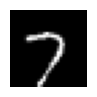

In [7]:
# MNIST
def prepare_dataloader_MNIST(path="MNIST/.", batch_size=64, shuffle=True):
    at_t_dataset_train = torchvision.datasets.MNIST(
        root=path, train=True, download=True
    )

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))] # MNIST chỉ có 1 channel
    )

    dataset = NumpyDataset(
        at_t_dataset_train.data.numpy(),
        at_t_dataset_train.targets.numpy(),
        transform=transform,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )

    shape_img = (28, 28)
    num_classes = 10
    channel = 1
    hidden = 588

    num_seeds = 5

    return dataloader, shape_img, num_classes, channel, hidden, num_seeds

# Xuất thông tin từ hàm
dataloader, shape_img, num_classes, channel, hidden, num_seeds = prepare_dataloader_MNIST()
PrintInfomation(dataloader, shape_img, num_classes, channel, hidden, num_seeds)

Files already downloaded and verified
Shape of images: (62, 47)
Number of classes: 4038
Number of channels: 3
Hidden layer size: 768
Number of seeds: 5
-----------------
Batch size: 64
Image shape: torch.Size([64, 3, 250, 250])
Labels shape: torch.Size([64])


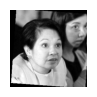

In [12]:
# LFW
def prepare_dataloader_LFW(path="LFW/.", batch_size=64, shuffle=True):
    from torchvision.datasets import LFWPeople
    from torchvision import transforms

    transform = transforms.Compose(
        [
            transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Chuẩn hóa ảnh
        ]
    )

    dataset = torchvision.datasets.LFWPeople(
        root=path, split="train", download=True, transform=transform
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )

    # Cấu hình cho LFW dataset
    shape_img = (62, 47)  # Kích thước ảnh LFW
    num_classes = len(set(dataset.targets))  # Số lượng người trong dataset LFW
    channel = 3  # Số kênh đầu vào (ảnh màu)
    hidden = 768  # Số lượng ẩn (có thể điều chỉnh)

    num_seeds = 5

    return dataloader, shape_img, num_classes, channel, hidden, num_seeds

# Xuất thông tin từ hàm
dataloader, shape_img, num_classes, channel, hidden, num_seeds = prepare_dataloader_LFW()
PrintInfomation(dataloader, shape_img, num_classes, channel, hidden, num_seeds)

Files already downloaded and verified
Shape of images: (32, 32)
Number of classes: 10
Number of channels: 3
Hidden layer size: 768
Number of seeds: 5
-----------------
Batch size: 64
Image shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])


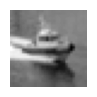

In [14]:
# CIFAR-10
def prepare_dataloader_CIFAR10(path="CIFAR10/.", batch_size=64, shuffle=True):
    at_t_dataset_train = torchvision.datasets.CIFAR10(
        root=path, train=True, download=True
    )

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))]
    )

    dataset = NumpyDataset(
        at_t_dataset_train.data,  # Dữ liệu CIFAR-10
        at_t_dataset_train.targets,  # Nhãn CIFAR-10
        transform=transform,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )

    shape_img = (32, 32)
    num_classes = 10  # Số lớp cho CIFAR-10
    channel = 3  # Số kênh đầu vào cho CIFAR-10
    hidden = 768  # Có thể điều chỉnh giá trị này nếu cần

    num_seeds = 5

    return dataloader, shape_img, num_classes, channel, hidden, num_seeds

# Xuất thông tin từ hàm
dataloader, shape_img, num_classes, channel, hidden, num_seeds = prepare_dataloader_CIFAR10()
PrintInfomation(dataloader, shape_img, num_classes, channel, hidden, num_seeds)

Files already downloaded and verified
Shape of images: (32, 32)
Number of classes: 100
Number of channels: 3
Hidden layer size: 768
Number of seeds: 5
-----------------
Batch size: 64
Image shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])


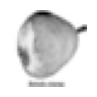

In [15]:
# CIFAR-100
def prepare_dataloader_CIFAR100(path="CIFAR100/.", batch_size=64, shuffle=True):
    at_t_dataset_train = torchvision.datasets.CIFAR100(
        root=path, train=True, download=True
    )

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))]
    )

    dataset = NumpyDataset(
        at_t_dataset_train.data,  # Dữ liệu CIFAR-100
        at_t_dataset_train.targets,  # Nhãn CIFAR-100
        transform=transform,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )

    shape_img = (32, 32)
    num_classes = 100  # Số lớp cho CIFAR-100
    channel = 3  # Số kênh đầu vào cho CIFAR-100
    hidden = 768  # Có thể điều chỉnh giá trị này nếu cần

    num_seeds = 5

    return dataloader, shape_img, num_classes, channel, hidden, num_seeds

# Xuất thông tin từ hàm
dataloader, shape_img, num_classes, channel, hidden, num_seeds = prepare_dataloader_CIFAR100()
PrintInfomation(dataloader, shape_img, num_classes, channel, hidden, num_seeds)

## Reconstruct Single Data

First, we try to recover the following private image from the received gradients with the batch size of 1.

### DLG

You can convert the normal server to the malicious attacker with `GradientInversionAttackServerManager`.

https://dlg.mit.edu/assets/NeurIPS19_deep_leakage_from_gradients.pdf

- distance metric = L2 norm
- optimize labels

Files already downloaded and verified
communication 0, epoch 0: client-1 4.7457804679870605


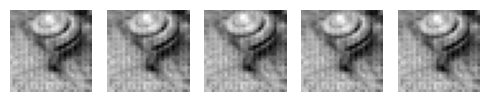

In [88]:
dataloader, shape_img, num_classes, channel, hidden, num_seeds = prepare_dataloader_CIFAR100()
for data in dataloader:
    xs, ys = data[0], data[1]
    break

x = xs[:1]
y = ys[:1]

manager = GradientInversionAttackServerManager(
    (channel, shape_img[0], shape_img[1]),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=100,
    distancename="l2",
    device=device,
    lr=1.0,
)

DLGFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)
server = DLGFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from torchvision.datasets import LFWPeople
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import numpy as np


# Chuẩn bị dữ liệu LFW
transform = transforms.Compose(
    [
        transforms.Resize((62, 47)),  # Giữ kích thước ảnh LFW mặc định
        transforms.ToTensor(),  # Chuyển đổi sang Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Chuẩn hóa
    ]
)

lfw_dataset = LFWPeople(root="LFW/.", split="train", transform=transform, download=False)
lfw_loader = DataLoader(lfw_dataset, batch_size=32, shuffle=True)

# Lấy mẫu dữ liệu để minh họa
x, y = next(iter(lfw_loader))  # Batch đầu tiên
x, y = x.to("cuda"), y.to("cuda")

# Cấu hình tham số
input_shape = (3, 62, 47)  # Ảnh LFW có 3 kênh, kích thước 62x47
num_classes = len(lfw_dataset.classes)  # Số lớp tương ứng với số người
hidden = 768
device = "cuda" if torch.cuda.is_available() else "cpu"

# Khởi tạo các thành phần của FedAVG
manager = GradientInversionAttackServerManager(
    input_shape,
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=100,
    tv_reg_coef=0.01,
    distancename="cossim",
    device=device,
    lr=0.1,
)
GSFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=3, hideen=hidden, num_classes=num_classes).to(device),
    lr=0.1,
    device=device,
)
server = GSFedAVGServer(
    [client],
    LeNet(channel=3, hideen=hidden, num_classes=num_classes).to(device),
    lr=0.1,
    device=device,
)

# Chuẩn bị DataLoader và Optimizer
local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=0.1)]

api = FedAVGAPI(
    server,
    [client],
    criterion=torch.nn.CrossEntropyLoss(),
    local_optimizers=local_optimizers,
    local_dataloaders=local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

# Chạy thuật toán
api.run()

# Minh họa kết quả tấn công
fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy().transpose(1, 2, 0))  # Hiển thị ảnh màu
    ax.axis("off")
plt.tight_layout()
plt.show()


### GS Attack

https://arxiv.org/abs/2003.14053

- distance metric = cosine similarity
- optimize labels
- regularization: total-variance

In [19]:
# lr=0.1
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=100,
    tv_reg_coef=0.01,
    distancename="cossim",
    device=device,
    lr=0.1,
)
GSFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=0.1,
    device=device,
)
server = GSFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=0.1,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=0.1)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

communication 0, epoch 0: client-1 2.236091375350952


RuntimeError: Given groups=1, weight of size [12, 3, 5, 5], expected input[1, 1, 28, 28] to have 3 channels, but got 1 channels instead

### iDLG Attack

https://arxiv.org/abs/2001.02610

- distance metric = L2 norm
- analytically estimate a label from the gradients

communication 0, epoch 0: client-1 2.371312141418457


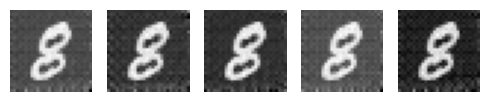

In [ ]:
# lr=1.0
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=1000,
    optimizer_class=torch.optim.SGD,
    distancename="l2",
    optimize_label=False,
    device=device,
    lr=1.0,
)
iDLGFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)
server = iDLGFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

### CPL Attack

https://arxiv.org/abs/2004.10397

- distance metric = L2 norm
- analytically estimate an label from the gradients
- regularization: label-matching

communication 0, epoch 0: client-1 2.371311902999878


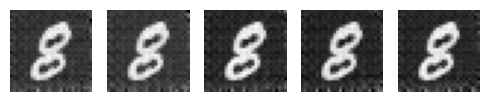

In [ ]:
# lr=1.0
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=1000,
    optimizer_class=torch.optim.SGD,
    distancename="l2",
    optimize_label=False,
    lm_reg_coef=0.01,
    lr=1.0,
)
CPLFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes), lr=1.0
)
server = CPLFedAVGServer(
    [client], LeNet(channel=channel, hideen=hidden, num_classes=num_classes), lr=1.0
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Reconstruct Batched Data

Second, we simulate the situatino with larger batch size. We try to recover the bellow three images.

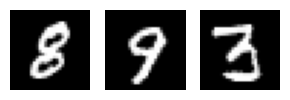

In [10]:
batch_size = 3
x_batch = xs[:batch_size]
y_batch = ys[:batch_size]

fig = plt.figure(figsize=(3, 2))
for bi in range(batch_size):
    ax = fig.add_subplot(1, batch_size, bi + 1)
    ax.imshow(x_batch[bi].detach().numpy()[0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

### GradInversion

https://arxiv.org/abs/2104.07586

- distance metric = L2 norm
- analytically estimate labels from the gradients
- reguralization: total-variance, l2, bn, and group-consistency

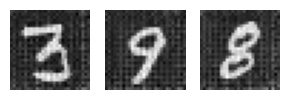

In [11]:
from aijack.attack.inversion import GradientInversion_Attack

net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x_batch)
loss = criterion(pred, y_batch)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gradinversion = GradientInversion_Attack(
    net,
    (1, 28, 28),
    num_iteration=1000,
    lr=1e2,
    log_interval=0,
    optimizer_class=torch.optim.SGD,
    distancename="l2",
    optimize_label=False,
    bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
    group_num=3,
    tv_reg_coef=0.00,
    l2_reg_coef=0.0001,
    bn_reg_coef=0.001,
    gc_reg_coef=0.001,
)

result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

fig = plt.figure(figsize=(3, 2))
for bid in range(batch_size):
    ax1 = fig.add_subplot(1, batch_size, bid + 1)
    ax1.imshow((sum(result[0]) / len(result[0])).detach().numpy()[bid][0], cmap="gray")
    ax1.axis("off")
plt.tight_layout()
plt.show()